In [22]:
!pip install jax optax matplotlib


/usr/local/Cellar/python@3.12/3.12.5/Frameworks/Python.framework/Versions/3.12/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 60.9 kB/s eta 0:00:00a 0:00:06
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 80.1 kB/s eta 0:00:00a 0:00:02m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 67.5 kB/s eta 0:00:00a 0:00:02m


In [24]:
from jax import numpy as np

symbols = ["H", "H"]
coordinates = np.array([[0.0, 0.0, -0.6614], [0.0, 0.0, 0.6614]])

In [25]:
import pennylane as qml

molecule = qml.qchem.Molecule(symbols, coordinates)
H, qubits = qml.qchem.molecular_hamiltonian(molecule)
print("Number of qubits = ", qubits)
print("The Hamiltonian is ", H)

Number of qubits =  4
The Hamiltonian is  -0.04207258319021251 * I(0) + 0.17771357885624406 * Z(0) + -0.2427450018665981 * Z(2) + 0.12293330325930762 * (Z(0) @ Z(2)) + 0.17771357885624406 * Z(1) + 0.17059759175283729 * (Z(0) @ Z(1)) + 0.04475008435343763 * (Y(0) @ X(1) @ X(2) @ Y(3)) + -0.04475008435343763 * (Y(0) @ Y(1) @ X(2) @ X(3)) + -0.04475008435343763 * (X(0) @ X(1) @ Y(2) @ Y(3)) + 0.04475008435343763 * (X(0) @ Y(1) @ Y(2) @ X(3)) + -0.2427450018665981 * Z(3) + 0.16768338761274526 * (Z(0) @ Z(3)) + 0.12293330325930762 * (Z(1) @ Z(3)) + 0.16768338761274526 * (Z(1) @ Z(2)) + 0.1762766129379404 * (Z(2) @ Z(3))


In [29]:
dev = qml.device("lightning.qubit", wires=qubits)

In [30]:
electrons = 2
hf = qml.qchem.hf_state(electrons, qubits)
print(hf)

[1 1 0 0]


In [31]:
@qml.qnode(dev)
def circuit(param, wires):
    qml.BasisState(hf, wires=wires)
    qml.DoubleExcitation(param, wires=[0, 1, 2, 3])
    return qml.expval(H)

In [32]:
def cost_fn(param):
    return circuit(param, wires=range(qubits))

In [33]:
import optax

max_iterations = 100
conv_tol = 1e-06

opt = optax.sgd(learning_rate=0.4)

In [34]:
import jax

theta = np.array(0.)

# store the values of the cost function
energy = [cost_fn(theta)]

# store the values of the circuit parameter
angle = [theta]

opt_state = opt.init(theta)

for n in range(max_iterations):

    gradient = jax.grad(cost_fn)(theta)
    updates, opt_state = opt.update(gradient, opt_state)
    theta = optax.apply_updates(theta, updates)

    angle.append(theta)
    energy.append(cost_fn(theta))

    conv = np.abs(energy[-1] - energy[-2])

    if n % 2 == 0:
        print(f"Step = {n},  Energy = {energy[-1]:.8f} Ha")

    if conv <= conv_tol:
        break

print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
print("\n" f"Optimal value of the circuit parameter = {angle[-1]:.4f}")

Step = 0,  Energy = -1.12799978 Ha
Step = 2,  Energy = -1.13466251 Ha
Step = 4,  Energy = -1.13590598 Ha
Step = 6,  Energy = -1.13613665 Ha
Step = 8,  Energy = -1.13617945 Ha
Step = 10,  Energy = -1.13618731 Ha
Step = 12,  Energy = -1.13618886 Ha

Final value of the ground-state energy = -1.13618886 Ha

Optimal value of the circuit parameter = 0.2089


/Users/thinhtran/Programming/Python/my312/lib/python3.12/site-packages/pennylane/math/utils.py:228: UserWarning: Contains tensors of types {'jax', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(
/Users/thinhtran/Programming/Python/my312/lib/python3.12/site-packages/pennylane/math/utils.py:228: UserWarning: Contains tensors of types {'jax', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(
/Users/thinhtran/Programming/Python/my312/lib/python3.12/site-packages/pennylane/math/utils.py:228: UserWarning: Contains tensors of types {'jax', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(
/Users/thinhtran/Programming/Python/my312/lib/python3.12/site-packages/pennylane/math/utils.py:228: UserWarning: Co

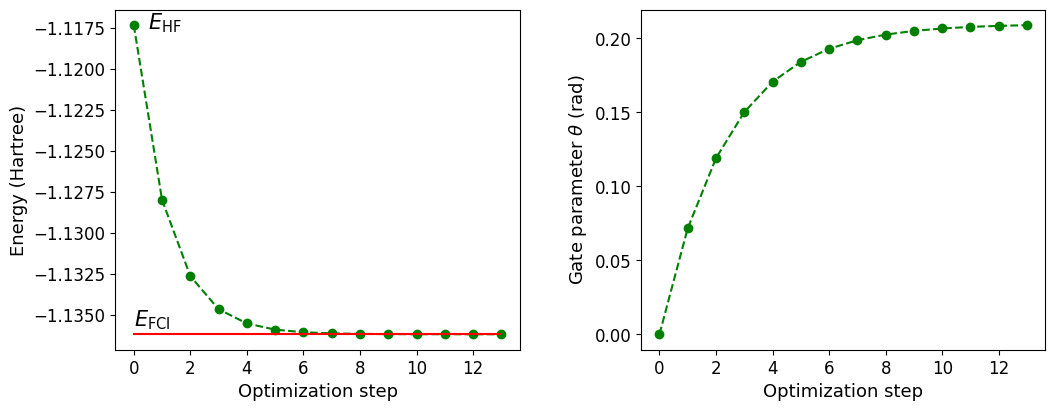

In [35]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

# Full configuration interaction (FCI) energy computed classically
E_fci = -1.136189454088

# Add energy plot on column 1
ax1 = fig.add_subplot(121)
ax1.plot(range(n + 2), energy, "go", ls="dashed")
ax1.plot(range(n + 2), np.full(n + 2, E_fci), color="red")
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("Energy (Hartree)", fontsize=13)
ax1.text(0.5, -1.1176, r"$E_\mathrm{HF}$", fontsize=15)
ax1.text(0, -1.1357, r"$E_\mathrm{FCI}$", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add angle plot on column 2
ax2 = fig.add_subplot(122)
ax2.plot(range(n + 2), angle, "go", ls="dashed")
ax2.set_xlabel("Optimization step", fontsize=13)
ax2.set_ylabel("Gate parameter $\\theta$ (rad)", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplots_adjust(wspace=0.3, bottom=0.2)
plt.show()